In [2]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

tf_gpu_options = tf.GPUOptions(allow_growth = True) # per_process_gpu_memory_fraction=0.12,
tf_session = tf.Session(config=tf.ConfigProto(gpu_options=tf_gpu_options))
tf.keras.backend.set_session(tf_session)


D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [ ]:
!curl -L http://nlp.stanford.edu/data/glove.twitter.27B.zip --output glove.twitter.27B.zip

In [ ]:
!unzip glove.twitter.27B.zip

In [3]:
GloVe_DIR = 'glove.twitter.27B.50d.txt'
DATA_DIR = './data'

In [4]:
# hyperparameter
MAX_SENT_LEN = 128
MAX_VOCAB_SIZE = 30000
LSTM_DIM = 100
EMBEDDING_DIM = 50
BATCH_SIZE = 128
N_EPOCHS = 40

In [5]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

In [6]:
train_bodies = pd.read_csv('./data/train_bodies.csv')
train_bodies.head(10)
test_bodies = pd.read_csv('./data/competition_test_bodies.csv')
test_bodies.head(10)

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...
5,20,“I once sent Tim an email about the quality of...
6,21,Absolutely no one was devastated when news bro...
7,28,In designing its first wearable device in the ...
8,31,"The picture of a possible ""Crabzilla"" measurin..."
9,33,"Early Tuesday morning, Dornella Conner was “ri..."


In [7]:
# load training data
train_df = pd.read_csv(DATA_DIR + '/train_stances.csv')
# load testing data
test_df = pd.read_csv(DATA_DIR + '/competition_test_stances.csv')

In [8]:
test_df.head(10)

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
5,Next-generation Apple iPhones' features leaked,2353,unrelated
6,Saudi national airline may introduce gender se...,192,unrelated
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated
9,Woman has surgery to get third breast: The thr...,85,unrelated


In [9]:
# numeralize the stance label
train_df.replace('unrelated',1,True)
train_df.replace('agree',2,True)
train_df.replace('disagree',3,True)
train_df.replace('discuss',4,True)

test_df.replace('unrelated',1,True)
test_df.replace('agree',2,True)
test_df.replace('disagree',3,True)
test_df.replace('discuss',4,True)

In [10]:
train_df.head(10)

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,1
1,Hundreds of Palestinians flee floods in Gaza a...,158,2
2,"Christian Bale passes on role of Steve Jobs, a...",137,1
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,1
4,Spider burrowed through tourist's stomach and ...,1923,3
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,2
6,Accused Boston Marathon Bomber Severely Injure...,962,1
7,Identity of ISIS terrorist known as 'Jihadi Jo...,2033,1
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,2
9,British Aid Worker Confirmed Murdered By ISIS,882,1


In [11]:
combine_df_train = train_df.join(train_bodies.set_index('Body ID'), on='Body ID')
combine_df_test = test_df.join(test_bodies.set_index('Body ID'), on='Body ID')

In [12]:
combine_df_test.head(10)

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,1,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,1,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,1,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,1,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,37,1,An airline passenger headed to Dallas was remo...
5,Next-generation Apple iPhones' features leaked,2353,1,When faced with the choice of feasting on a fi...
6,Saudi national airline may introduce gender se...,192,1,The US declared the video of Sotloff to be aut...
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,1,19-year-old Iga Jasica of Poland began making ...
8,"ISIS might be harvesting organs, Iraq tells UN",250,1,Michael Foley says the administration threaten...
9,Woman has surgery to get third breast: The thr...,85,1,Brian Stelter from CNN just reported that hack...


In [13]:
combine_df_train.head(10)

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,1,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,2,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,1,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,1,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,3,"Fear not arachnophobes, the story of Bunbury's..."
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,2,Thousands of people have been duped by a fake ...
6,Accused Boston Marathon Bomber Severely Injure...,962,1,A British fighter who travelled to Iraq to sto...
7,Identity of ISIS terrorist known as 'Jihadi Jo...,2033,1,"Adding to Apple's iOS 8 launch troubles, a rep..."
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,2,If you’ve seen a story floating around on your...
9,British Aid Worker Confirmed Murdered By ISIS,882,1,The British Islamic State militant who has fea...


In [14]:
# text to wordsequence
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]

word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [15]:
print('90th Percentile Sentence of headline:', np.percentile([len(seq) for seq in word_seq_head_train], 90))

90th Percentile Sentence of headline: 16.0


In [16]:
print('90th Percentile Sentence of body:', np.percentile([len(seq) for seq in word_seq_bodies_train], 90))

90th Percentile Sentence of body: 683.0


In [17]:
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])


In [18]:
# Use tokenizer API to map each token to a unique integer
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
#because it only includes unique words(tokens)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 27873


In [19]:
# Combine headline and body together
word_seq_train = [list(i) for i in word_seq_head_train]
for i in range(len(word_seq_head_train)):
    word_seq_train[i].extend(word_seq_bodies_train[i]) 
    
word_seq_test = [list(i) for i in word_seq_head_test]
for i in range(len(word_seq_head_test)):
    word_seq_test[i].extend(word_seq_bodies_test[i])

In [20]:
len(word_seq_train)

49972

In [21]:
# Shorten the sentence to a fixed length
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = combine_df_train['Stance']

In [22]:
y_train.shape

(49972,)

In [23]:
# Convert the sequence of words to sequnce of indices
X_test = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test])
X_test = pad_sequences(X_test, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_test = combine_df_test['Stance']

In [24]:
y_test.shape

(25413,)

In [25]:
# Encode class values as integers
encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)

In [27]:
y_train.shape

(44974, 4)

In [28]:
# Encode class values as integers
encoder_test = LabelEncoder()
encoder_test.fit(y_test)
encoded_test = encoder_test.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = np_utils.to_categorical(encoded_test)

In [29]:
y_test.shape

(25413, 4)

# build the model


In [30]:
# Load GloVe as embedding layer
glove_input_file = GloVe_DIR
word2vec_output_file = 'glove.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

D:\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [32]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
        #none: if words in sentence don't have pre-trained corresponding embedding, then error occurs

    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        #if pre-trained word embedding exists，then let embeddings_matrix[i] is this embedding
        #Wi:the ith row of embeddings_matrix
        
del embeddings
#delete

In [33]:
# Build a sequential model by stacking neural net units 
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', #False
                          mask_zero=True))
#mask_zero is to deal with padding problem
model_1.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model_1.add(Dropout(rate=0.8, name='dropout_1')) 
model_1.add(Dense(4, activation='softmax', name='output_layer'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#  The first model we use is Bidirectional LSTM(baseline)


In [34]:
# compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
# checkpoint the model of each epoch, and save them in the checkpoint folder
filepath="./checkpoint/Bidirectional_lstm_300Length_40epoch_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list1 = [checkpoint]

#  train model


In [36]:
# get the training history of the model in each epoch
history_1 = model_1.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          callbacks=callbacks_list1,
          validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 44974 samples, validate on 4998 samples
Epoch 1/40
44974/44974 [==============================] - 217s 5ms/step - loss: 0.7858 - acc: 0.7286 - val_loss: 0.6709 - val_acc: 0.7521
Epoch 2/40
44974/44974 [==============================] - 237s 5ms/step - loss: 0.6152 - acc: 0.7740 - val_loss: 0.5464 - val_acc: 0.7969
Epoch 3/40
44974/44974 [==============================] - 242s 5ms/step - loss: 0.4746 - acc: 0.8237 - val_loss: 0.4339 - val_acc: 0.8379
Epoch 4/40
44974/44974 [==============================] - 237s 5ms/step - loss: 0.3917 - acc: 0.8549 - val_loss: 0.3751 - val_acc: 0.8603
Epoch 5/40
44974/44974 [==============================] - 239s 5ms/step - loss: 0.3358 - acc: 0.8749 - val_loss: 0.3362 - val_acc: 0.8725
Epoch 6/40
44974/44974 [==============================] - 238s 5ms/step - loss: 0.2879 - acc: 0.8926 - val_loss: 0.3014 - val_acc: 0.8804
Epoch 7/40
44974/44974 [==============================] - 233s 5ms/step - l

In [52]:
# it is for save the model training history
with open('./history/history(Bidirectional_lstm_300Length_40epoch_training)', 'wb') as f:
        pickle.dump(history_1.history, f)

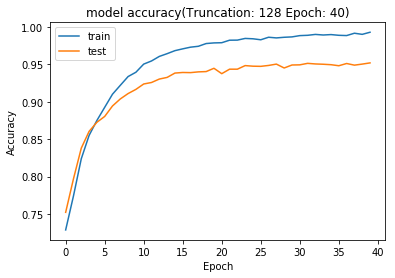

In [51]:
# open the trainging history of the model in each epoch, and plot the accuracy and loss curve
file1 = open('./history/history(Bidirectional_lstm_300Length_40epoch_training)', 'rb')
history_1 = pickle.load(file1)
file1.close()

plt.plot(history_1['acc'])
plt.plot(history_1['val_acc'])
plt.title('model accuracy(Truncation: 128 Epoch: 40)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

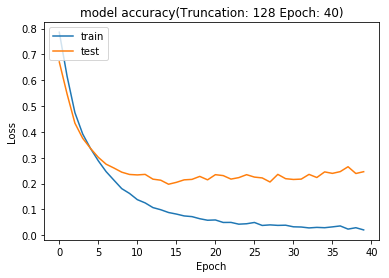

In [52]:
plt.plot(history_1['loss'])
plt.plot(history_1['val_loss'])
plt.title('model accuracy(Truncation: 128 Epoch: 40)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#  Prediction


In [30]:
# load the trained model with the best accuracy
from keras import models
model_file_path = './checkpoint/Bidirectional_lstm_300Length_40epoch_40_0.9520.h5'
model_1 = models.load_model(model_file_path)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [32]:
# predict the stance of the competition test
prediction = model_1.predict(X_test)
preds = [np.argmax(p, axis = -1) for p in prediction]
actuals = [np.argmax(p, axis = -1) for p in y_test]

In [33]:
for i in range(len(preds)):
    if preds[i] == 0: preds[i] = "unrelated"
    if preds[i] == 1: preds[i] = "disagree"
    if preds[i] == 2: preds[i] = "agree"
    if preds[i] == 3: preds[i] = "discuss"

for i in range(len(actuals)):
    if actuals[i] == 0: actuals[i] = "unrelated"
    if actuals[i] == 1: actuals[i] = "disagree"
    if actuals[i] == 2: actuals[i] = "agree"
    if actuals[i] == 3: actuals[i] = "discuss"

In [34]:
stance_list = preds
bodyid_list = []
headline_list = []

In [35]:
test_df_original_1 = pd.read_csv(DATA_DIR + '/competition_test_stances.csv')
test_df_original_1.head(10)

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated
5,Next-generation Apple iPhones' features leaked,2353,unrelated
6,Saudi national airline may introduce gender se...,192,unrelated
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated
9,Woman has surgery to get third breast: The thr...,85,unrelated


In [36]:
# save the result of the prediction for submission
for i in range(len(test_df_original_1.Stance)):
    bodyid_list.append(test_df_original_1['Body ID'][i])
    headline_list.append(test_df_original_1.Headline[i])
   
df = pd.DataFrame(data={'Headline': headline_list, 'Body ID': bodyid_list, "Stance": stance_list})
df.to_csv("bidirectional_LSTM_submission.csv")

In [37]:
score, acc = model_1.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

25413/25413 [==============================] - 65s 3ms/step


In [38]:
acc

0.6909062290997426

# Improve the model, add more layers to bidirectional LSTM, the outcome turns out to be better, but too time consuming. So it is not included in our poster  and final report

In [80]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting
model_2.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))

model_2.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
model_2.add(Activation(activation='relu', name='activation_1'))
model_2.add(Dropout(rate=0.2, name='dropout_2'))
model_2.add(Activation(activation='relu', name='activation_2'))

model_2.add(Dense(4, activation='softmax', name='output_layer'))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1798950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               120800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 804       
Total para

In [81]:
#CALLBACK FUCTION: TO SAVE MODEL FOR EVERY EPOCH END
filepath="./checkpoints/FNC-1_BASIC_LSTM_150_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list = [checkpoint]

In [83]:
optimizer = optimizers.Adam(lr=0.001)
model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [84]:
history_2 = model_2.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_valid, y_valid)
         )


Train on 44974 samples, validate on 4998 samples
Epoch 1/40
44974/44974 [==============================] - 212s 5ms/step - loss: 0.8226 - acc: 0.7275 - val_loss: 0.7343 - val_acc: 0.7433
Epoch 2/40
44974/44974 [==============================] - 224s 5ms/step - loss: 0.7357 - acc: 0.7414 - val_loss: 0.6746 - val_acc: 0.7431
Epoch 3/40
44974/44974 [==============================] - 221s 5ms/step - loss: 0.6540 - acc: 0.7510 - val_loss: 0.5940 - val_acc: 0.7667
Epoch 4/40
44974/44974 [==============================] - 241s 5ms/step - loss: 0.5955 - acc: 0.7664 - val_loss: 0.5427 - val_acc: 0.7843
Epoch 5/40
44974/44974 [==============================] - 230s 5ms/step - loss: 0.5436 - acc: 0.7853 - val_loss: 0.4845 - val_acc: 0.8043
Epoch 6/40
44974/44974 [==============================] - 210s 5ms/step - loss: 0.4984 - acc: 0.8038 - val_loss: 0.4602 - val_acc: 0.8147
Epoch 7/40
44974/44974 [==============================] - 209s 5ms/step - loss: 0.4591 - acc: 0.8203 - val_loss: 0.4325 - v

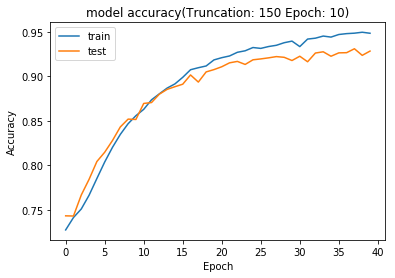

In [85]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy(Truncation: 150 Epoch: 10)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction for improved bidirectional LSTM


In [86]:
score, acc = model_2.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
acc

25413/25413 [==============================] - 58s 2ms/step


0.7145948923708805

# Bidirectional LSTM + Attention(Our second model)

In [41]:
#only attend first 15 states
class Attention(Layer):
    def __init__(self, attention_length = 20 ,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                  **kwargs):

        #self.supports_masking = True
        #Xavier uniform initializer
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.attention_length = 30
        self.features_dim = 100 
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        
        self.Wy = self.add_weight((self.features_dim,self.features_dim),
                                 initializer=self.init,
                                 name='{}_Wy'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        

        
        self.Wh = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wh'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.w = self.add_weight((self.features_dim,1),
                                     initializer=self.init,
                                     name='{}_x'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.Wp = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wp'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        
        self.Wx = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wx'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        
        Y_states = tf.slice(x, begin = [0, 0, 0], size = [-1, self.attention_length, -1]) #15 first states
        h_state = x[:,-1,:]
        print ("h_state",h_state.shape)
        #print ("wh", self.Wh.shape)
        features_dim = self.features_dim

        M1 = K.reshape(K.dot(K.reshape(Y_states, (-1, features_dim)), self.Wy),shape = (-1,self.attention_length,features_dim ))
        #print("here")
        M2 = K.expand_dims(K.dot(h_state, self.Wh),axis=1)
        M = K.tanh(M1+M2)
        #print("here2")
        alpha = K.reshape(K.softmax(K.dot(K.reshape(M, shape = (-1, features_dim)), self.w)), shape = (-1, self.attention_length))
        r = tf.squeeze(tf.matmul(tf.transpose(tf.expand_dims(alpha, 2), perm = [0, 2, 1]), Y_states))
        h_star = tf.tanh(tf.matmul(r, self.Wp) + tf.matmul(h_state, self.Wx))
        

        return h_star

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [80]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1, input_length =MAX_SENT_LEN,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable= True, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model_2.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))

model_2.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2

model_2.add(Attention())

model_2.add(Dense(4, activation='softmax', name='output_layer'))
model_2.summary()

h_state (?, 100)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 128, 50)           1393700   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 128, 100)          60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
attention_4 (Attention)      (None, 100)               40100     
_________________________________________________________________
output_layer (Dense)         (None, 4)                 404       
Total params: 1,494,604
Trainable params: 1,494,604
Non-trainable params: 0
_________________________________________________________________


In [81]:
optimizer = optimizers.Adam(lr=0.001) 

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [82]:
# save 4 history.keys of each epoch, though some epoch maybe omitted
filepath="./checkpoint/LSTM_with_attention_128Length_40Epoch_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list2 = [checkpoint]

In [83]:
history_2 = model_2.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks = callbacks_list2)

Train on 44974 samples, validate on 4998 samples
Epoch 1/40
44974/44974 [==============================] - 150s 3ms/step - loss: 0.7505 - acc: 0.7383 - val_loss: 0.6703 - val_acc: 0.7599
Epoch 2/40
44974/44974 [==============================] - 145s 3ms/step - loss: 0.6098 - acc: 0.7775 - val_loss: 0.5445 - val_acc: 0.7989
Epoch 3/40
44974/44974 [==============================] - 154s 3ms/step - loss: 0.4886 - acc: 0.8191 - val_loss: 0.4377 - val_acc: 0.8377
Epoch 4/40
44974/44974 [==============================] - 157s 3ms/step - loss: 0.4158 - acc: 0.8456 - val_loss: 0.3877 - val_acc: 0.8579
Epoch 5/40
44974/44974 [==============================] - 155s 3ms/step - loss: 0.3553 - acc: 0.8674 - val_loss: 0.3467 - val_acc: 0.8721
Epoch 6/40
44974/44974 [==============================] - 158s 4ms/step - loss: 0.3119 - acc: 0.8835 - val_loss: 0.3231 - val_acc: 0.8780
Epoch 7/40
44974/44974 [==============================] - 142s 3ms/step - loss: 0.2790 - acc: 0.8959 - val_loss: 0.3094 - v

In [84]:
# it is for saving the model training history
with open('./history/history(LSTM_with_attention_128Length_40Epoch_training)', 'wb') as f:
        pickle.dump(history_2.history, f)

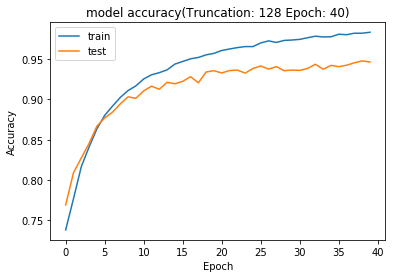

In [66]:
# plot the accuracy and loss of the bidirectional LSTM + attention
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy(Truncation: 128 Epoch: 40)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

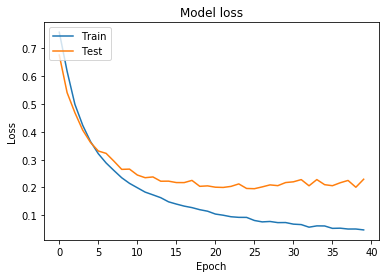

In [68]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction for LSTM with attention

In [42]:
# Load the best model with best accuracy from checkpoint folder
from keras import models
model_file_path = './checkpoint/LSTM_with_attention_128Length_40Epoch_lr=0.001_39_0.9478.h5'
model_2 = models.load_model(model_file_path,custom_objects = {'Attention': Attention()})

h_state (?, 100)


In [43]:
prediction = model_2.predict(X_test)
preds = [np.argmax(p, axis = -1) for p in prediction]
actuals = [np.argmax(p, axis = -1) for p in y_test]

In [44]:
for i in range(len(preds)):
    if preds[i] == 0: preds[i] = "unrelated"
    if preds[i] == 1: preds[i] = "disagree"
    if preds[i] == 2: preds[i] = "agree"
    if preds[i] == 3: preds[i] = "discuss"

for i in range(len(actuals)):
    if actuals[i] == 0: actuals[i] = "unrelated"
    if actuals[i] == 1: actuals[i] = "disagree"
    if actuals[i] == 2: actuals[i] = "agree"
    if actuals[i] == 3: actuals[i] = "discuss"

In [45]:
stance_list = preds
bodyid_list = []
headline_list = []

In [46]:
test_df_original_2 = pd.read_csv(DATA_DIR + '/competition_test_stances.csv')


In [47]:
# save the result for final submission
for i in range(len(test_df_original_2.Stance)):
    bodyid_list.append(test_df_original_2['Body ID'][i])
    headline_list.append(test_df_original_2.Headline[i])
   
df = pd.DataFrame(data={'Headline': headline_list, 'Body ID': bodyid_list, "Stance": stance_list})
df.to_csv("bidirectional_LSTM_attention_submission.csv")

In [48]:
score, acc = model_2.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
acc

25413/25413 [==============================] - 36s 1ms/step


0.7057805060352316